# 四种天气图片的分类和卷积神经网络

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import os
import shutil

## 划分数据集
将数据集图片按照类别划分到不同的文件夹中

In [2]:
# torchvision.datasets.ImageFolder    ImageFolder类用于读取图片数据集，它假设所有的图片按照类别放在不同的文件夹中，每个文件夹的名字就是类别的名字
# 创建数据集文件夹划分后的训练集和测试集文件夹
base_dir = r'./dataset/4weather' # 数据集的根目录
specises = ['cloudy', 'rain', 'shine', 'sunrise']       # 数据集的类别
if not os.path.isdir(base_dir):     # 判断文件夹是否存在
    os.mkdir(base_dir)              # 创建文件夹
    train_dir = os.path.join(base_dir, 'train')     # 训练集的文件夹
    test_dir = os.path.join(base_dir, 'test')       # 测试集的文件夹
    os.mkdir(train_dir)             # 创建训练集文件夹
    os.mkdir(test_dir)              # 创建测试集文件夹

    # 分别在训练集和测试集中创建类别文件夹
    for train_or_test in ['train', 'test']:
        for spec in specises:
            os.mkdir(os.path.join(base_dir, train_or_test, spec))

In [3]:
# 将数据集的图片复制到对应的类别文件夹中
image_dir = r'./dataset/Weather'        # 数据集图片的原始存放文件夹

for i, img in enumerate(os.listdir(image_dir)):     # listdir()返回指定路径下的文件和文件夹列表， enumerate()函数返回可枚举对象
    for spec in specises:           # 遍历类别
        if spec in img:             # 判断图片名中是否包含类别名
            s = os.path.join(image_dir, img)    # 拼接图片路径
            if i%5 == 0:
                d = os.path.join(base_dir, 'test', spec, img)
            else:
                d = os.path.join(base_dir, 'train', spec, img)
            shutil.copy(s, d)       # 复制图片

# 查看训练集和测试集的图片数量
for train_or_test in ['train', 'test']:
    for spec in specises:
        print(train_or_test, spec, len(os.listdir(os.path.join(base_dir, train_or_test, spec))))

train cloudy 240
train rain 172
train shine 202
train sunrise 286
test cloudy 60
test rain 43
test shine 51
test sunrise 71


In [ ]:
from torchvision import transforms

In [ ]:
transform = transforms.Compose([
                  transforms.Resize((96, 96)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                       std=[0.5, 0.5, 0.5])
])

In [ ]:
train_ds = torchvision.datasets.ImageFolder(
               train_dir,
               transform=transform
)

In [ ]:
test_ds = torchvision.datasets.ImageFolder(
               test_dir,
               transform=transform
)

In [ ]:
train_ds.classes

['cloudy', 'rain', 'shine', 'sunrise']

In [ ]:
train_ds.class_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [ ]:
len(train_ds), len(test_ds)

(900, 225)

In [ ]:
BATCHSIZE = 16

In [ ]:
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BATCHSIZE,
                                       shuffle=True
)

In [ ]:
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BATCHSIZE,
)

In [ ]:
imgs, labels = next(iter(train_dl))

In [ ]:
imgs.shape

torch.Size([16, 3, 96, 96])

In [ ]:
imgs[0].shape

torch.Size([3, 96, 96])

In [ ]:
im = imgs[0].permute(1, 2, 0)

In [ ]:
im.shape

torch.Size([96, 96, 3])

In [ ]:
im = im.numpy()

In [ ]:
type(im)

numpy.ndarray

In [ ]:
im.shape

(96, 96, 3)

In [ ]:
im = (im + 1)/2

In [ ]:
im.max(), im.min()

(1.0, 0.035294116)

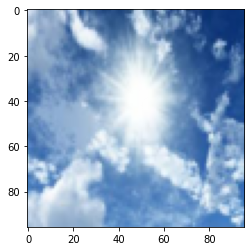

In [ ]:
plt.imshow(im)

In [ ]:
labels[0]

tensor(2)

In [ ]:
train_ds.class_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [ ]:
id_to_class = dict((v, k) for k, v in train_ds.class_to_idx.items())

In [ ]:
id_to_class

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

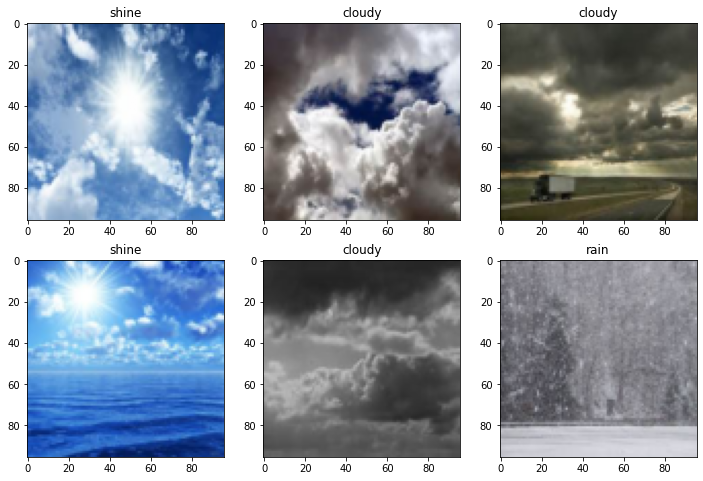

In [ ]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.title(id_to_class.get(label.item()))
    plt.imshow(img)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.drop(x)
#        print(x.size())
        x = x.view(-1, 64*10*10)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [ ]:
model = Net()

In [ ]:
preds = model(imgs)

In [ ]:
imgs.shape

torch.Size([16, 3, 96, 96])

In [ ]:
preds.shape

torch.Size([16, 4])

In [ ]:
torch.argmax(preds, 1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
if torch.cuda.is_available():
    model.to('cuda')

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#此处使用训练代码

In [ ]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [ ]:
epochs = 30

In [ ]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.046 accuracy: 0.69 test_loss：  0.053 test_accuracy: 0.751
epoch:  1 loss：  0.029 accuracy: 0.814 test_loss：  0.037 test_accuracy: 0.818
epoch:  2 loss：  0.027 accuracy: 0.839 test_loss：  0.037 test_accuracy: 0.822
epoch:  3 loss：  0.021 accuracy: 0.878 test_loss：  0.033 test_accuracy: 0.836
epoch:  4 loss：  0.02 accuracy: 0.883 test_loss：  0.04 test_accuracy: 0.862
epoch:  5 loss：  0.017 accuracy: 0.897 test_loss：  0.033 test_accuracy: 0.889
epoch:  6 loss：  0.013 accuracy: 0.919 test_loss：  0.037 test_accuracy: 0.871
epoch:  7 loss：  0.009 accuracy: 0.941 test_loss：  0.035 test_accuracy: 0.876
epoch:  8 loss：  0.012 accuracy: 0.922 test_loss：  0.036 test_accuracy: 0.893
epoch:  9 loss：  0.008 accuracy: 0.954 test_loss：  0.047 test_accuracy: 0.876
epoch:  10 loss：  0.006 accuracy: 0.964 test_loss：  0.05 test_accuracy: 0.88
epoch:  11 loss：  0.004 accuracy: 0.981 test_loss：  0.052 test_accuracy: 0.893
epoch:  12 loss：  0.006 accuracy: 0.966 test_loss：  0.038 test_accu

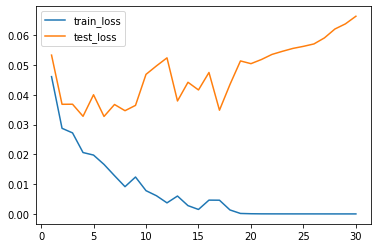

In [ ]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

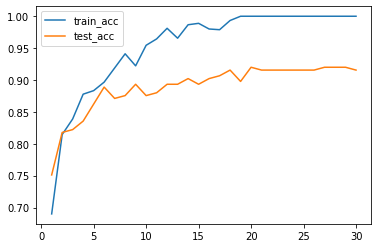

In [ ]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

# 添加dropout层

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [ ]:
model = Net()
if torch.cuda.is_available():
    model.to('cuda')

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 30

In [ ]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.05 accuracy: 0.654 test_loss：  0.042 test_accuracy: 0.733
epoch:  1 loss：  0.032 accuracy: 0.768 test_loss：  0.036 test_accuracy: 0.791
epoch:  2 loss：  0.029 accuracy: 0.811 test_loss：  0.04 test_accuracy: 0.747
epoch:  3 loss：  0.026 accuracy: 0.83 test_loss：  0.033 test_accuracy: 0.84
epoch:  4 loss：  0.02 accuracy: 0.89 test_loss：  0.034 test_accuracy: 0.871
epoch:  5 loss：  0.017 accuracy: 0.881 test_loss：  0.041 test_accuracy: 0.84
epoch:  6 loss：  0.017 accuracy: 0.901 test_loss：  0.036 test_accuracy: 0.84
epoch:  7 loss：  0.014 accuracy: 0.929 test_loss：  0.032 test_accuracy: 0.871
epoch:  8 loss：  0.009 accuracy: 0.943 test_loss：  0.047 test_accuracy: 0.889
epoch:  9 loss：  0.007 accuracy: 0.958 test_loss：  0.049 test_accuracy: 0.88
epoch:  10 loss：  0.007 accuracy: 0.967 test_loss：  0.037 test_accuracy: 0.893
epoch:  11 loss：  0.004 accuracy: 0.978 test_loss：  0.045 test_accuracy: 0.898
epoch:  12 loss：  0.002 accuracy: 0.987 test_loss：  0.039 test_accuracy

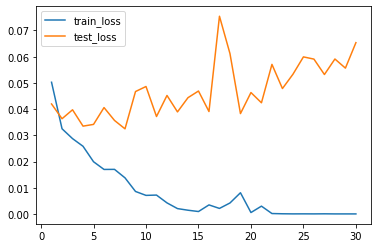

In [ ]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

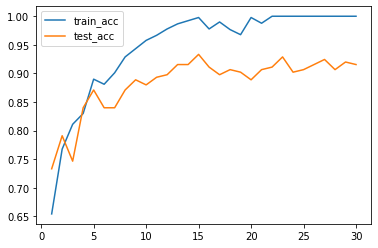

In [ ]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()